## Использование предварительно обученной сверточной нейронной сети

In [5]:
import keras
import numpy as np
import os
import warnings
warnings.simplefilter('ignore')
from keras.applications import VGG16

In [6]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Быстрое выделение признаков с использованием предварительно обученной сверточной основы без расширения данных

In [12]:
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) #т.к. заключительная карта признаков имеет форму (4, 4, 512)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size = batch_size, 
                                            class_mode='binary')
    i = 0 
    for input_batch, labels_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = feature_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 6000)
valid_features, valid_labels = extract_features(valid_dir, 3000)
tes_features, test_labels = extract_features(test_dir, 3000)


Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


NameError: name 'test_features' is not defined

Приведём к форме (образцы, 8192)

In [14]:
train_features = np.reshape(train_features, (6000, 4*4*512))
valid_features = np.reshape(valid_features, (3000, 4*4*512))
tes_features = np.reshape(tes_features, (3000, 4*4*512))

Полносвязный классификатор

In [19]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit(train_features,
                    train_labels, 
                    epochs=30, 
                    batch_size=20, 
                    validation_data=(valid_features, valid_labels))

Train on 6000 samples, validate on 3000 samples
Epoch 1/30
6000/6000 [==============================] - 10s 2ms/step - loss: 0.4824 - acc: 0.7597 - val_loss: 0.3193 - val_acc: 0.8743
Epoch 2/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.3202 - acc: 0.8637 - val_loss: 0.2784 - val_acc: 0.8947
Epoch 3/30
6000/6000 [==============================] - 9s 1ms/step - loss: 0.2799 - acc: 0.8790 - val_loss: 0.2532 - val_acc: 0.8880
Epoch 4/30
6000/6000 [==============================] - 10s 2ms/step - loss: 0.2526 - acc: 0.8932 - val_loss: 0.2399 - val_acc: 0.8977
Epoch 5/30
6000/6000 [==============================] - 10s 2ms/step - loss: 0.2337 - acc: 0.9042 - val_loss: 0.2322 - val_acc: 0.9013
Epoch 6/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.2202 - acc: 0.9083 - val_loss: 0.2291 - val_acc: 0.8983
Epoch 7/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.2082 - acc: 0.9178 - val_loss: 0.2237 - val_acc: 0.9037
Epoch 8/30


Графики

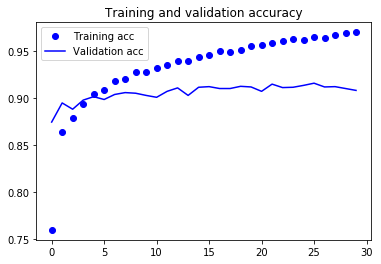

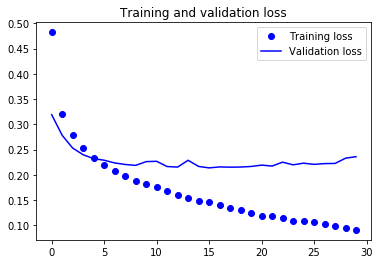

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
test_generator = datagen.flow_from_directory(test_dir,
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('acc:', test_acc)

Found 3000 images belonging to 2 classes.


ValueError: Error when checking input: expected dense_7_input to have 2 dimensions, but got array with shape (20, 150, 150, 3)